In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.tree_util import Partial
import numpy as np
import matplotlib.pyplot as plt

import flax
import flax.linen as nn
import optax
from functools import partial
from typing import Callable, Any, Optional, Tuple
from flax.linen import initializers
from flax.linen.linear import default_kernel_init

PRNGKey = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?
Array = Any
Carry = Any
CarryHistory = Any
Output = Any

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Systèmes dynamiques. 
Une EDO (équation différentielle ordinaire) permet de décrire l'évolution d'un système dynamique dans le temps en spécifiant la pente d'une variable en fonction du temps. Plus précisément, un tel système est de la forme: 
\begin{align*}
    \dot{\boldsymbol{y}}(t) = f(\boldsymbol{y}, t) \enspace, 
\end{align*}
où $\dot{\boldsymbol{y}}(t)$ signifie la dérivée temporelle (sa "vitesse") de la variable dépendente $\boldsymbol{y}$. Un tel système peut-être simulé à partir d'un état initial $x(0) = x_0$ donné par l'entremise de la méthode d'Euler qui calcule $x_{k+1} = x_{k} + h f(x_k; kh)$ itérativement pour un nombre donné de pas de taille $h$. 


Utilisez la méthode d'euler pour simuler le système: 
\begin{align*}
\dot x_1 &= -\gamma_1 x_1 + \kappa_1 s^{-}(x_2, \theta_2) \\
\dot x_2 &= -\gamma_2 x_2 + \kappa_2 s^{-}(x_1, \theta_1)\\
s^{-}(x,\theta)&= \begin{cases}
    1 & \text{si } x < \theta, \\
    0 & \text{si } x > \theta,
    \end{cases}
\end{align*}
avec $\kappa_1 = 1, \kappa_2 = 1, \gamma_1 = 1.2, \gamma_2 = 2, \theta_1 = 0.6, \theta_2 = 0.4$. Ce système dynamique est un modèle simple d'un interrupteur biologique, ou "commutateur biologique" qui est un dispositif génétique permettant à une cellule de passer entre deux états stables en réponse à un signal externe ou interne. Ce mécanisme est utilisé pour contrôler l'expression des gènes et pour réguler les processus biologiques dans les cellules. 


A) Visualizez le champs vectoriel de ce système à l'aide de matplotlib.pyplot.streamplot

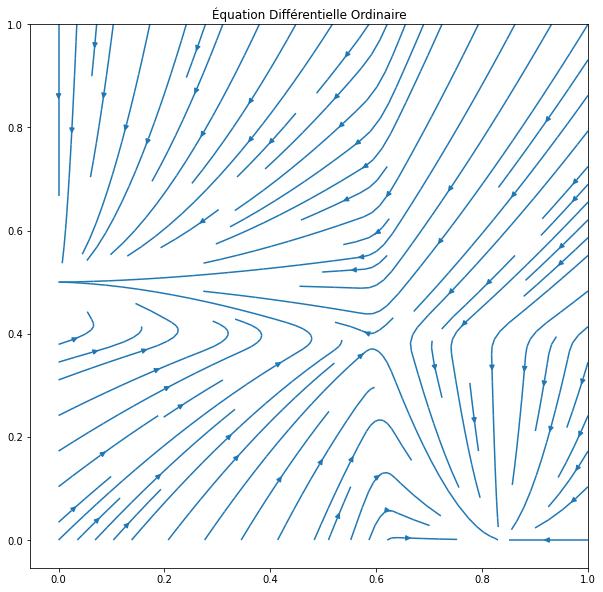

In [ ]:
# Declarations des variables avec leur valeur donnée dans l'énoncé
# gamma
g1 = 1.2
g2 = 2.0
# k
k1 = 1.0
k2 = 1.0
# theta
t1 = 0.6
t2 = 0.4

# valeurs arbitraires pour l'affichage
Size = 10
coef = 0.1

def SMoins(x, theta):
  return np.where(x < theta, 1, 0)

def EquationDiff(g1, g2, k1, k2, t1, t2, x):
  x1, x2 = x
  # xpoint1 = -gamma1*x1 + k1*SMoins(x2, theta2)
  dx1 = -g1 * x1 + k1 * SMoins(x2, t2)
  # xpoint2 = -gamma2*x2 + k2*SMoins(x1, theta1)
  dx2 = -g2 * x2 + k2 * SMoins(x1, t1)
  return dx1, dx2

def AfficherGraphique():
  linspace = np.linspace(0, 1, 20)
  linspace2 = np.linspace(0, 1, 20)
  meshgridx = np.meshgrid(linspace, linspace2)
  dx1, dx2 = EquationDiff(g1, g2, k1, k2, t1, t2, meshgridx)
  graphique = plt.figure(figsize=(10, 10))
  ax = graphique.add_subplot()
  x1 = meshgridx[0]
  x2 = meshgridx[1]
  plt.streamplot(x1, x2, dx1, dx2)
  plt.title("Équation Différentielle Ordinaire")

def main():
  x1 = np.zeros(Size)
  x2 = np.zeros(Size)

  for i in range(Size-1):
    dx1, dx2 = EquationDiff(g1, g2, k1, k2, t1, t2, [x1[i], x2[i]])
    x1[i+1] = x1[i] + coef*dx1
    x2[i+1] = x2[i] + coef*dx2
  
  AfficherGraphique()

main()

B) Générez des trajectoires de ce système et les superposer sur la figure du champ vectoriel

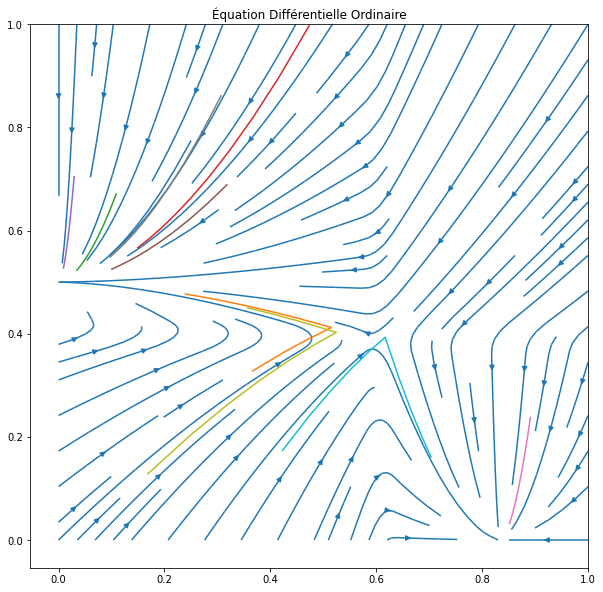

In [ ]:
def init(nbTraj):
  t = []

  # On genere des valeurs aleatoires de taille nbTraj, 2
  randomVals = np.random.rand(nbTraj, 2)

  # pour chacune des valeur aleatoire
  for randomVal in randomVals:
    x1 = np.zeros(Size)
    x2 = np.zeros(Size)

    x1[0] = randomVal[0]
    x2[0] = randomVal[1]

    # de 1 jusqua Size-1
    for i in range(Size-1):
      dx1, dx2 = EquationDiff(g1, g2, k1, k2, t1, t2, [x1[i], x2[i]])
      x1[i+1] = x1[i] + coef*dx1
      x2[i+1] = x2[i] + coef*dx2

    # on rajoute [x1, x2] a t
    t.append([x1, x2])
    
  # on retourne un array construit a partir de t
  return np.array(t)

traj = init(Size)
AfficherGraphique()
for i in range(len(traj)):
  plt.plot(traj[i][0], traj[i][1])


C) Ayant amassé un jeu de données de trajectoires dans la question précédente, apprenez un RNN qui reproduit les dynamiques du système d'origine en temps discret. Visualisez les trajectoires apprises en les surimposant sur le champs vectoriel.

In [ ]:
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib

# Install ml-collections & latest Flax version from Github.
!pip install --upgrade -q git+https://github.com/google/flax.git

  Preparing metadata (setup.py) ... done


In [ ]:
class Your_RNN_Cell(nn.RNNCellBase):
  # Implement your own RNN cell, by adding the layers and activation you want in call()
  kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = (
      default_kernel_init)
  bias_init: Callable[[PRNGKey, Shape, Dtype], Array] = initializers.zeros_init()
  dtype: Optional[Dtype] = None
  param_dtype: Dtype = jnp.float32


  gate_fn: Callable[..., Any] = nn.sigmoid
  activation_fn: Callable[..., Any] = nn.tanh
  kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = (
      default_kernel_init)
  recurrent_kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = (
      initializers.orthogonal())
  bias_init: Callable[[PRNGKey, Shape, Dtype], Array] = initializers.zeros_init()
  dtype: Optional[Dtype] = None
  param_dtype: Dtype = jnp.float32

  @nn.compact
  def __call__(self, carry, inputs):
    h, prev_y = carry #tuple
    hidden_features = h.shape[-1]
    # input and recurrent layers are summed so only one needs a bias.
    dense_h = partial(nn.Dense,
                      features=hidden_features,
                      use_bias=False,
                      dtype=self.dtype,
                      param_dtype=self.param_dtype,
                      kernel_init=self.recurrent_kernel_init,
                      bias_init=self.bias_init)
    dense_i = partial(nn.Dense,
                      features=hidden_features,
                      use_bias=True,
                      dtype=self.dtype,
                      param_dtype=self.param_dtype,
                      kernel_init=self.kernel_init,
                      bias_init=self.bias_init)
    dense_o = partial(nn.Dense,
                      features=2,#2 hardcoded feat.
                      use_bias=True,
                      dtype=self.dtype,
                      param_dtype=self.param_dtype,
                      kernel_init=self.kernel_init,
                      bias_init=self.bias_init)
    
    new_h = self.activation_fn(dense_h()(prev_y)) + self.activation_fn(dense_h()(h))
    out = nn.sigmoid(dense_o()(new_h))
    return (new_h, out), out # Respectively: next_carry, cell_output

  @staticmethod
  def initialize_carry(rng, batch_dims, size, init_fn=initializers.zeros_init()):
    k1, k2 = jax.random.split(rng)
    mem_shape = batch_dims + (size,)
    return init_fn(k1, mem_shape), init_fn(k2, batch_dims+(2,))

# test
x = np.ones((10, 50, 32)) # (batch, time, features)
rnn = nn.RNN(Your_RNN_Cell(), cell_size=64)
variables = rnn.init(jax.random.PRNGKey(0), x)
y = rnn.apply(variables, x)
y.shape # (batch, time, cell_size) # Should be (10, 50, 2)

ImportError: ignored

In [ ]:
# We need dummy trajectories
def free_fall(g, angle, v0):
  x = jnp.arange(0,1,0.1)
  return -g*x**2/(jnp.cos(angle)*2*v0**2) + x*jnp.tan(angle)

def trajectory_fn(init): # smaller earth or smaller moon?
  angle, v0 = init[0], init[1]
  return jnp.stack([free_fall(9.807, angle, v0), free_fall(1.62, angle, v0)], axis=-1)

In [ ]:
# Training loop: Expect to it nan if training on dummy trajectories

@jax.jit
def mse_loss(x ,y):
  return 0.5 * jnp.sum((x-y)**2)/(x.shape[0]*x.shape[1])

def flax_get_loss_and_update_fn(model, loss, optimizer):
  @jax.jit
  def loss_fn(params, batch):
    targets = batch
    init_carry = batch[:,0,:]
    shpe = (batch.shape[0], model.cell_size)
    init_carry = (jnp.zeros(shpe), init_carry)
    return loss(model.apply(params, batch, initial_carry=init_carry), targets)

  @jax.jit
  def update_fn(opt_state, params, batch):
    grad = jax.grad(loss_fn)(params, batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state
  
  return loss_fn, update_fn

class data_loader():

  def __init__(self, bs, seed) -> None:
    self.bs = bs

  def __next__(self):
    trajectories = np.transpose(init(self.bs), axes=(0,2,1))
    return trajectories

# load and test data_loader
data = data_loader(32, 42)
print(next(data).shape) # Should be 32, horizon/delta_t, 2
print(next(data))

# instanciate a model
model = nn.RNN(Your_RNN_Cell(), cell_size=32)

# Initialize the model parameters
params = model.init(jax.random.PRNGKey(0), next(data))

# Create an optimizer with optax
max_learning_rate = 0.01
training_steps = 25000
lr_schedule = optax.cosine_onecycle_schedule(training_steps, max_learning_rate)
optimizer = optax.adam(lr_schedule)
opt_state = optimizer.init(params)

# Get loss and update fn
loss, update = flax_get_loss_and_update_fn(model, mse_loss, optimizer)

for step in range(training_steps+1):
  if step % 500 == 0:
    # Periodically evaluate classification accuracy on train & test sets and display progress.
    current_loss = jax.device_get(loss(params, next(data)))
    print(f"[Step {step}] Loss: {current_loss:.3f}.")

  # if step % 100 == 0:
  #   # Records metrics periodically
  #   log_metrics(record, params, next(train_eval), next(test_eval))
  

  # Do training on a batch of training examples.
  params, opt_state = update(opt_state, params, next(data))



In [ ]:
def AfficherTrajectoirePredite():
  t = next(data)
  targets = t
  init_carry = t[:,0,:]
  newShape = (t.shape[0], model.cell_size)
  init_carry = (jnp.zeros(newShape), init_carry)
  test_t = model.apply(params, t, initial_carry=init_carry)
  AfficherGraphique()
  for i in range(Size):
    plt.plot(test_t[i, :, 0], test_t[i, :, 1])

AfficherTrajectoirePredite()

## 2. Convolution causales dilatées.
Un CNN causal à 1 dimension pour la génération de séquences est
un modèle de la forme:
$$p(\boldsymbol{y})=\prod_{t=1}^T p\left(y_t \mid \boldsymbol{y}_{1: t-1}\right)=\prod_{t=1}^T \operatorname{Cat}\left(y_t \mid \operatorname{softmax}\left(\varphi\left(\sum_{\tau=1}^{t-k} \boldsymbol{w}^{\top} \boldsymbol{y}_{\tau: \tau+k}\right)\right)\right)$$

où φ est un non-linéarité et w est un filtre de taille k. La sommation à l’intérieur est une convolu-
tion causale, c’est-à-dire, une convolution qui ne prend en compte que les valeurs passées de y lors
de l’application du filtre w. Une telle convolution causale est identique à une convolution discrete
habituelle, à la différence que les entrées futures au temps t sont cachées/masquées. Ce type de
modèle peut-être utilisé en remplacement des réseaux récurrents pour la génération de séquences.
2. Implémentez et calculez la convolution causale de $\boldsymbol{y} =[1, 2, 3, 4, 5]$ et $\boldsymbol{w} = [0.5, 0.25, -0.1]$. Vous pouvez utiliser la définition donnée ci-haut ou bien à l'aide de numpy.convolve.

In [ ]:
def convolve(y, w):
  # on calcule la longueur de la convolution
  # comme ce sont des array de seulement une dimension, on peut obtenir la longueur avec len(w)
  longueurPad = len(w) - 1

  # on fait du zero padding pour ajouter des 0
  ypadded = np.concatenate([np.zeros(longueurPad), y]) 

  convolution = np.convolve(ypadded, w, mode='valid')
  print(convolution)

  # ici on a 
  # W (*) Y = (-0.1*0 + 0.25*0 + 0.5*1) (-0.1*0 + 0.25*1 + 0.5*2) (-0.1*1 + 0.25*2 + 0.5*3) (-0.1*2 + 0.25*3 + 0.5*4) (-0.1*3 + 0.25*4 + 0.5*5)
  # W (*) Y = (0.5) (1.25) (1.9) (2.55) (3.2) 
# on initialise les variables y et w
y = np.array([1,2,3,4,5])
w = np.array([0.5,0.25,-0.1])
convolve(y,w)



[0.5  1.25 1.9  2.55 3.2 ]


3. Une convolution dilatée, également appelée convolution à trous, est une convolution où le filtre contient des "trous"/zéros avec un espacement donné. Ces trous permettent d'augmenter la taille effective du filtre tout en gardant le nombre de paramètres constant. La convolution à trous avec une dilatation de 2 sur le filtre $\boldsymbol{w}$ est calculée à l'aide de $\boldsymbol{w}^{(2)} = [0.5, 0., 0.25, 0., -0.1]$. 

a. Implémentez et calculez la convolution causale de $\boldsymbol{y}$ avec $\boldsymbol{w}^{(2)}$ à l'aide de numpy.convolve
        

In [ ]:
def dilatedConvolution(y, w, d):
  # We dilate the window use the dilation value
  dilatedW = np.zeros((len(w) + (len(w)- 1) * (d - 1)))
  dilatedW[::d] = w

  # We call the convolve method
  convolve(y, dilatedW)

  # ici on a 

  # Y = [ 0,      0,      0,      0,      1,      2,    3,      4,      5]
  # W = [ -0.1,   0,      0.25,   0,      0.5]                              = 0.5
  # W =         [ -0.1,   0,      0.25,   0,      0.5]                      = 1
  # W =                [ -0.1,   0,      0.25,   0,      0.5]               = 1.75
  # W =                         [ -0.1,   0,      0.25,   0,    0.5]        = 2.5
  # W =                                [ -0.1,   0,      0.25,   0,    0.5] = 3.15
y = np.array([1,2,3,4,5])
w = np.array([0.5,0.25,-0.1])
d = 2
dilatedConvolution(y,w,d)

[0.5  1.   1.75 2.5  3.15]
